# CPA

In [1]:
# -*- coding: utf-8 -*-
"""
Originally Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""
import numpy as np
from tqdm import tqdm 

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings("ignore")

## Constant

In [2]:
HW = [bin(n).count("1") for n in range(0,256)]

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

## Load Data

In [3]:
# 10,000 different traces - one trace contains 5,000 samples measured
# from the oscilloscope for an  AES single encryption 
traces = np.load('./chipwhisperer/traces.npy')[:-1] # discard last one empty measurement
# 10,000 different plaintext
pt = np.load('./chipwhisperer/plain.npy')
# 10,000 identical keys
knownkey = np.load('./chipwhisperer/key.npy')

assert traces.shape[0] == pt.shape[0]
assert pt.shape[0] == knownkey.shape[0]

## Guess Key

- Pearson Correlation Coefficient:
$$Pearson(x,y) = \frac{ \sum_{i=1}^N ( (x_i-\bar{x}) (y_i-\bar{y}) )}
{\sqrt{\sum_{i=1}^N (x_i-\bar{x})^2 \sum_{i=1}^N (y_i-\bar{y})^2}}$$

In [4]:
def intermediate(pt: np.array, keyguess: np.array):
    '''
    return the output of a s-box:
    pt: plaintext
    keyguess: subkey
    '''
    return sbox[pt ^ keyguess]

In [5]:
numtraces_max, numpoint = np.shape(traces)[0], np.shape(traces)[1]

# Use less than the maximum traces by setting numtraces to something
numtraces = 30
traces = traces[0:numtraces,:]

# Set 16 to something lower (like 1) to only go through a single subkey
bestguess = [0]*16
ge = np.zeros(16)
nsubkey = 1

In [6]:
for bnum in range(0, nsubkey):
    cpaoutput = [0]*256
    maxcpa = [0]*256

    for kguess in range(0, 256):
        #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

        # Initialize arrays &amp; variables to zero
        sumnum = np.zeros(numpoint)
        sumden1 = np.zeros(numpoint)
        sumden2 = np.zeros(numpoint)

        # the hamming distance of one block of all the selected traces
        # for the current kguess
        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]

        # Mean of hypothesis
        meanh = np.mean(hyp, dtype=np.float64)

        # Mean of all points in trace
        meant = np.mean(traces, axis=0, dtype=np.float64)

        # For each trace, do the following
        for tnum in range(0, numtraces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = traces[tnum, :] - meant
            sumnum += hdiff*tdiff
            sumden1 += hdiff*hdiff
            sumden2 += tdiff*tdiff

        # Pearson Correlation Coefficient
        cpaoutput[kguess] = sumnum / np.sqrt(sumden1 * sumden2)
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

    bestguess[bnum] = np.argmax(maxcpa)

    cparefs = np.argsort(maxcpa)[::-1]

    # Find GE
    ge[bnum] = list(cparefs).index(knownkey[0][bnum])

for b in range(0, nsubkey):
    print("Best Key Guess: ", bestguess[b], " GE: ", ge[b])

Best Key Guess:  43  GE:  0.0


## Visualization

The following cell is time-consuming. Uncomment it only if you want to run by yourself.

In [7]:
# all_traces = np.load('./chipwhisperer/traces.npy')[:-1]
# nsubkey = 16
# repetition = 10
# ntrace_range = 100
# GE_rep = []

# for rep in tqdm(range(repetition)):
#     GE = []
    
#     for numtraces in range(1, ntrace_range+1):
#         traces = all_traces[rep*100:rep*100+numtraces, :]

#         for bnum in range(0, nsubkey):
#             cpaoutput = [0]*256
#             maxcpa = [0]*256

#             for kguess in range(0, 256):
#                 #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

#                 # Initialize arrays &amp; variables to zero
#                 sumnum = np.zeros(numpoint)
#                 sumden1 = np.zeros(numpoint)
#                 sumden2 = np.zeros(numpoint)

#                 # the hamming distance of one block of all the selected traces
#                 # for the current kguess
#                 hyp = np.zeros(numtraces)
#                 for tnum in range(0, numtraces):
#                     hyp[tnum] = HW[intermediate(pt[rep*100+tnum][bnum], kguess)]

#                 # Mean of hypothesis
#                 meanh = np.mean(hyp, dtype=np.float64)

#                 # Mean of all points in trace
#                 meant = np.mean(traces, axis=0, dtype=np.float64)

#                 # For each trace, do the following
#                 for tnum in range(0, numtraces):
#                     hdiff = (hyp[tnum] - meanh)
#                     tdiff = traces[tnum, :] - meant
#                     sumnum += hdiff*tdiff
#                     sumden1 += hdiff*hdiff
#                     sumden2 += tdiff*tdiff

#                 # Pearson Correlation Coefficient
#                 cpaoutput[kguess] = sumnum / np.sqrt(sumden1 * sumden2)
#                 maxcpa[kguess] = max(abs(cpaoutput[kguess]))

#                 #print (maxcpa[kguess])

#             bestguess[bnum] = np.argmax(maxcpa)

#             cparefs = np.argsort(maxcpa)[::-1]

#             # Find GE
#             ge[bnum] = list(cparefs).index(knownkey[0][bnum])

#         GE.append(ge.copy())
#         # for b in range (0, nsubkey):
#         #     print ("Best Key Guess: ",bestguess[b], " GE: ", ge[b])
#     GE_rep.append(np.array(GE).copy())

In [8]:
# results = np.array(GE_rep)
# results_averge = results.mean(axis=0)
# np.savetxt("./savedata/ge_avg.txt", results_averge)

In [9]:
results_averge = np.round(np.loadtxt('./savedata/ge_avg.txt'))
# 10 repetitions, 100 traces for each time
results_averge.shape

(100, 16)

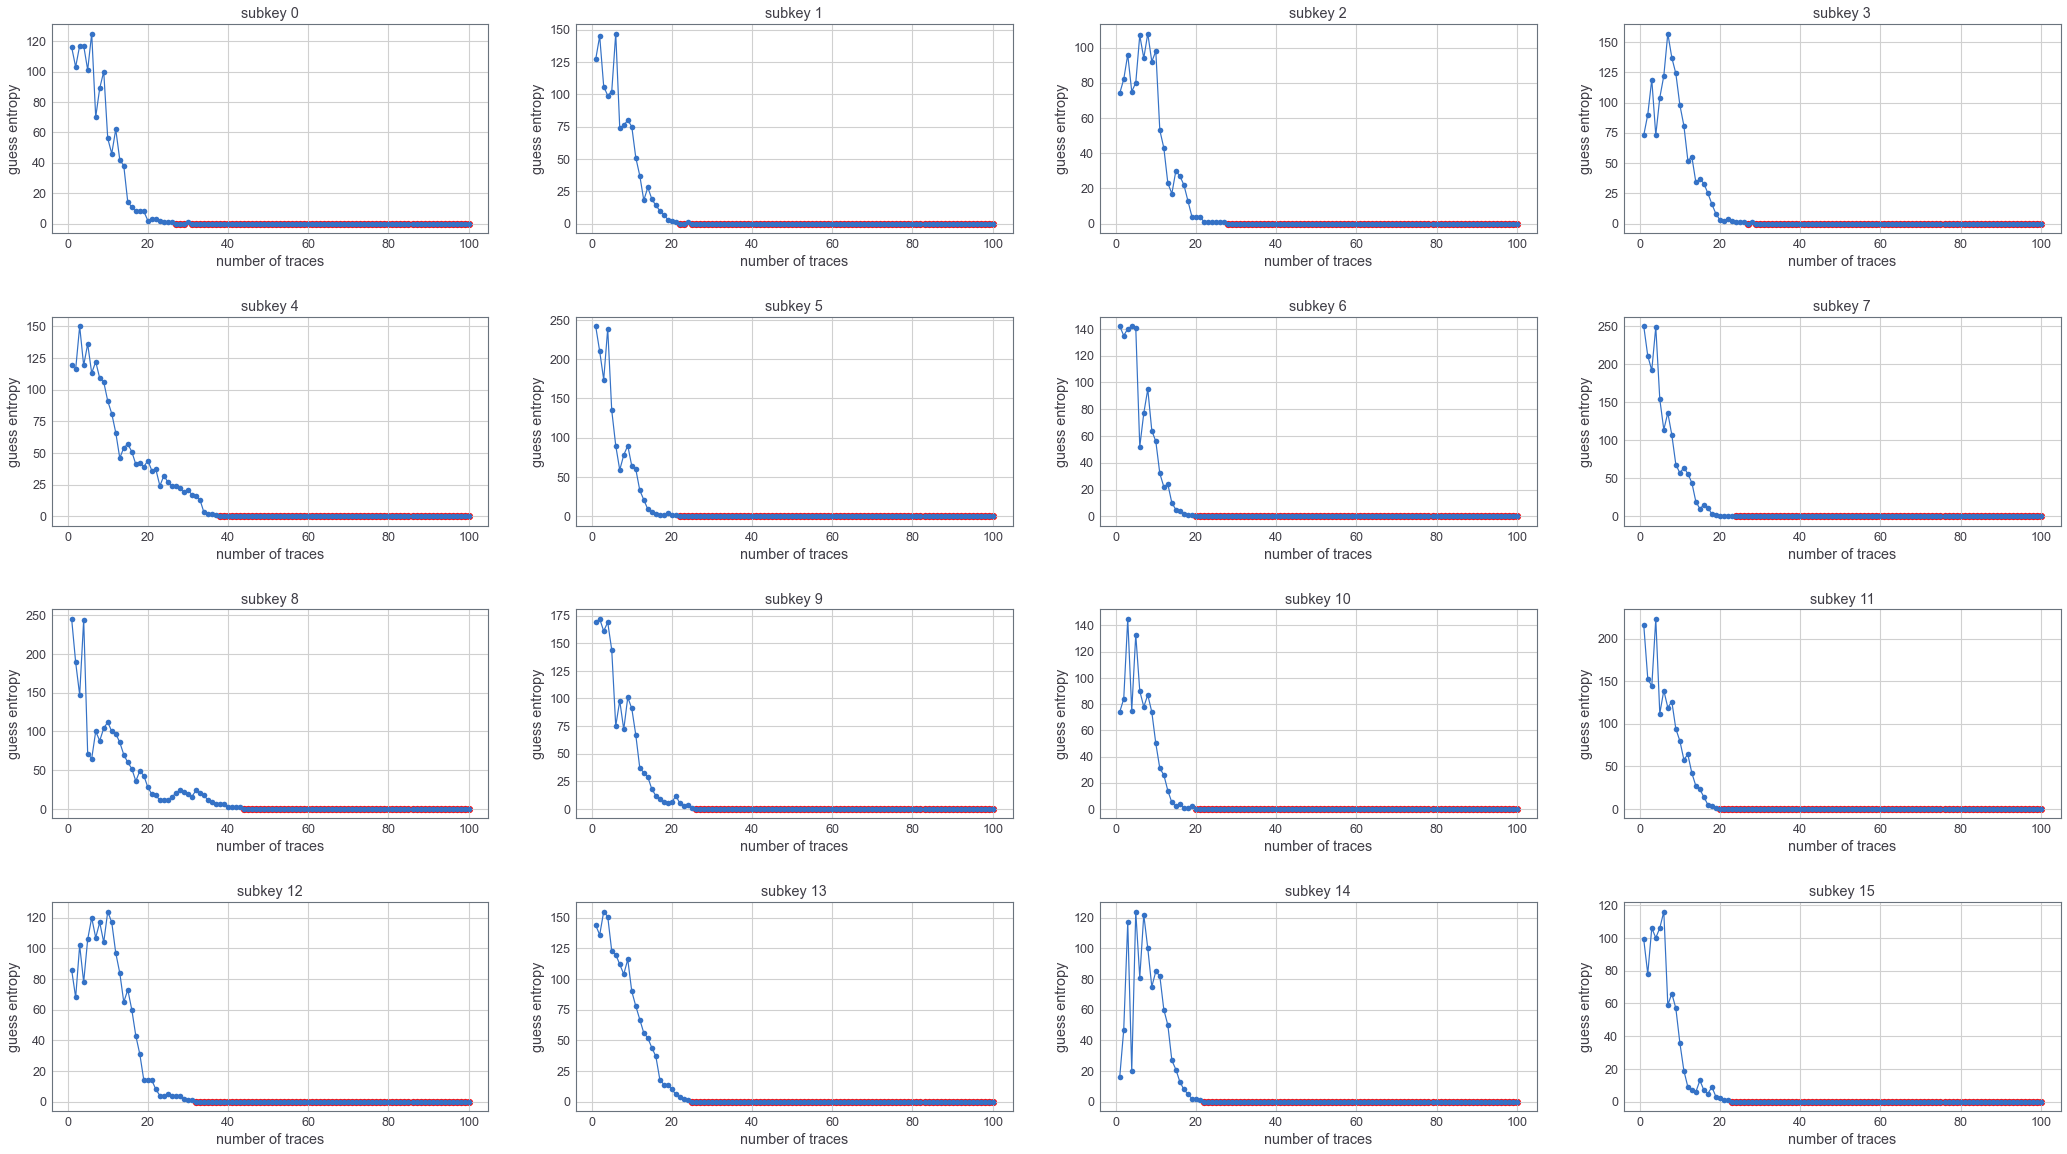

In [10]:
plt.figure(figsize=(36, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(np.arange(1,100+1), results_averge[:,i], '-o')
    plt.scatter(np.where(results_averge[:,i] == 0)[0]+1, results_averge[np.where(results_averge[:,i] == 0)[0],i], marker='o', c='red', s=50)
    plt.xlabel('number of traces')
    plt.ylabel('guess entropy')
    plt.title('subkey '+str(i))
# plt.savefig('./figures/CPA/subkey_ge.pdf', dpi=1200)
plt.show()

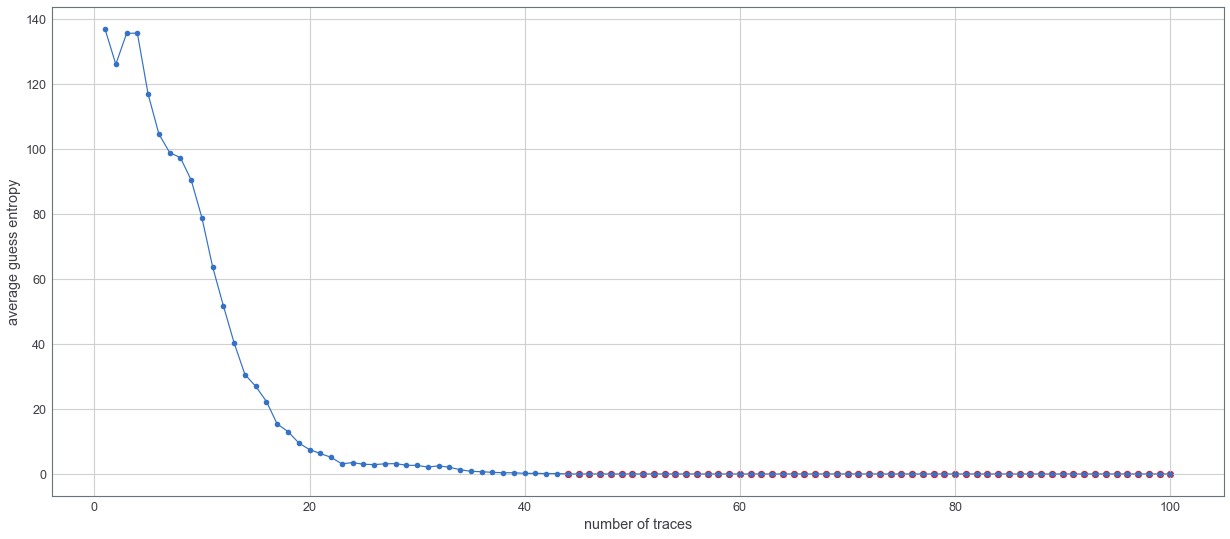

In [11]:
y = results_averge.mean(axis=1)
plt.figure(figsize=(21, 9))
plt.plot(np.arange(1,100+1), y, '-o')
plt.scatter(np.where(y == 0)[0]+1, y[np.where(y == 0)[0]], marker='o', c='red', s=50)
plt.xlabel('number of traces')
plt.ylabel('average guess entropy')
# plt.savefig('./figures/CPA/avg_ge.pdf', dpi=1200)
plt.show()

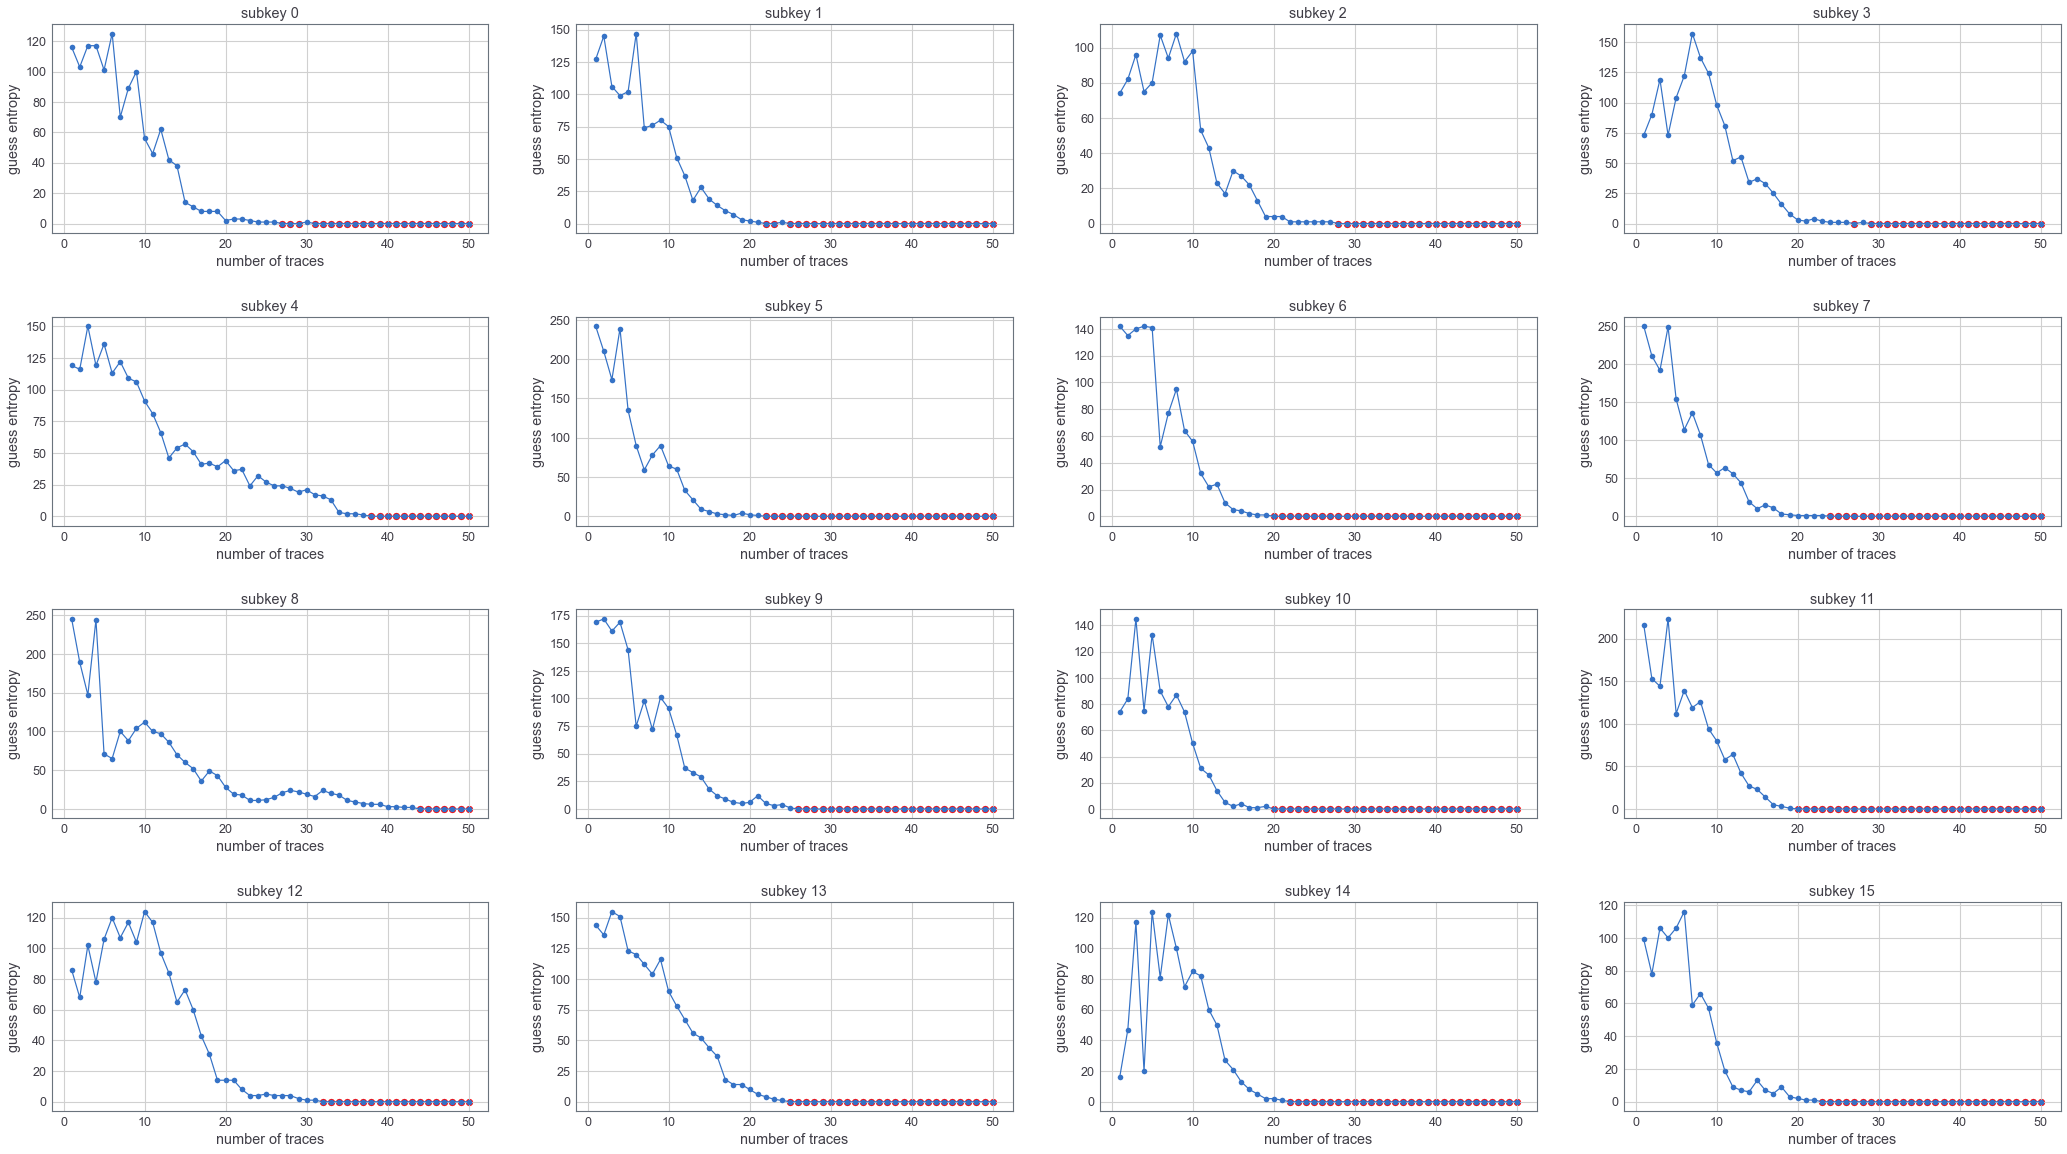

In [12]:
results_averge = np.round(np.loadtxt('./savedata/ge_avg.txt'))[:50,:]
# 10 repetitions, 100 traces for each time
results_averge.shape
plt.figure(figsize=(36, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(np.arange(1,50+1), results_averge[:,i], '-o')
    plt.scatter(np.where(results_averge[:,i] == 0)[0]+1, results_averge[np.where(results_averge[:,i] == 0)[0],i], marker='o', c='red', s=50)
    plt.xlabel('number of traces')
    plt.ylabel('guess entropy')
    plt.title('subkey '+str(i))
# plt.savefig('./figures/CPA/partial_subkey_ge.pdf', dpi=1200)
plt.show()

## Online CPA

### Load Data & Initialization

In [13]:
all_traces = np.load('./chipwhisperer/traces.npy')[:-1]
pt = np.load('./chipwhisperer/plain.npy')
knownkey = np.load('./chipwhisperer/key.npy')

numtraces_max, numpoint = np.shape(traces)[0], np.shape(traces)[1]

bestguess = [0]*16 
ge = np.zeros(16) 

### Global Variables to Store the Old Pearson Coefficient

In [14]:
sumhditdj = np.zeros([16, 256, numpoint])
sumhdi = np.zeros([16, 256, 1])
sumtdj = np.zeros([16, 256, numpoint])
sumhdi_2 = np.zeros([16, 256, 1])
sumtdj_2 = np.zeros([16, 256, numpoint])
D = 0

### Input Setting

In [15]:
nsubkey = 1  # how many subkeys you want to get, maximum 16
startpos = 20  # starting point of the input traces
numtraces = 26  # the number of traces

In [16]:
def online_cpa_init():
    global sumhditdj
    global sumhdi
    global sumtdj
    global sumhdi_2
    global sumtdj_2
    global D
    global bestguess
    global ge
    
    sumhditdj = np.zeros([16, 256, numpoint])
    sumhdi = np.zeros([16, 256, 1])
    sumtdj = np.zeros([16, 256, numpoint])
    sumhdi_2 = np.zeros([16, 256, 1])
    sumtdj_2 = np.zeros([16, 256, numpoint])
    D = 0
    
    bestguess = [0]*16 
    ge = np.zeros(16) 
    
    return None
    
def online_cpa(nsubkey=1, startpos=0, numtraces=5):
    global sumhditdj
    global sumhdi
    global sumtdj
    global sumhdi_2
    global sumtdj_2
    global D
    global bestguess
    global ge
    
    traces = all_traces[startpos:startpos+numtraces]  # input traces
    D += numtraces
    
    for bnum in range(0, nsubkey):
        cpaoutput = [0]*256
        maxcpa = [0]*256

        for kguess in range(0, 256):
            hyp = np.zeros(numtraces)
            for tnum in range(0, numtraces):
                hyp[tnum] = HW[intermediate(pt[startpos+tnum][bnum], kguess)]

            for tnum in range(0, numtraces):  # online CPA
                sumhditdj[bnum, kguess] += hyp[tnum] * traces[tnum]
                sumhdi[bnum, kguess] += hyp[tnum]
                sumtdj[bnum, kguess] += traces[tnum]
                sumhdi_2[bnum, kguess] += hyp[tnum] ** 2
                sumtdj_2[bnum, kguess] += traces[tnum] ** 2

            numerator = (D * sumhditdj[bnum, kguess] -
                         sumhdi[bnum, kguess] * sumtdj[bnum, kguess])
            denominator = np.sqrt(
                (sumhdi[bnum, kguess]**2 - D*sumhdi_2[bnum, kguess]) *
                (sumtdj[bnum, kguess]**2 - D*sumtdj_2[bnum, kguess])
            )
            cpaoutput[kguess] = numerator / denominator
            maxcpa[kguess] = max(abs(cpaoutput[kguess]))

        bestguess[bnum] = np.argmax(maxcpa)
        cparefs = np.argsort(maxcpa)[::-1]
        # Find GE
        ge[bnum] = list(cparefs).index(knownkey[0][bnum])

    for b in range(0, nsubkey):
        print("Kye ["+ str(b) +'] ', "Best Key Guess: ", bestguess[b], " GE: ", ge[b])
    
    return bestguess, ge

### Example of Usage

#### Example 1

In [17]:
# finding the first subkey by inputting traces one by one
online_cpa_init()
ge0 = np.inf
startpos = -1
numtraces = 1
searching_time = 0

while(ge0):
    searching_time += 1
    startpos += 1
    temp_bestguess, temp_ge = online_cpa(1, startpos, numtraces)
    ge0 = temp_ge[0]
    subkey0 = temp_bestguess[0]

print("Searching Times: ", searching_time, "Best Key Guess: ", subkey0, " GE: ", ge0)

Kye [0]  Best Key Guess:  0  GE:  116.0
Kye [0]  Best Key Guess:  8  GE:  133.0
Kye [0]  Best Key Guess:  19  GE:  120.0
Kye [0]  Best Key Guess:  60  GE:  116.0
Kye [0]  Best Key Guess:  60  GE:  56.0
Kye [0]  Best Key Guess:  60  GE:  196.0
Kye [0]  Best Key Guess:  60  GE:  77.0
Kye [0]  Best Key Guess:  59  GE:  89.0
Kye [0]  Best Key Guess:  233  GE:  47.0
Kye [0]  Best Key Guess:  1  GE:  34.0
Kye [0]  Best Key Guess:  45  GE:  10.0
Kye [0]  Best Key Guess:  12  GE:  112.0
Kye [0]  Best Key Guess:  45  GE:  55.0
Kye [0]  Best Key Guess:  200  GE:  24.0
Kye [0]  Best Key Guess:  2  GE:  10.0
Kye [0]  Best Key Guess:  2  GE:  15.0
Kye [0]  Best Key Guess:  2  GE:  9.0
Kye [0]  Best Key Guess:  2  GE:  1.0
Kye [0]  Best Key Guess:  2  GE:  42.0
Kye [0]  Best Key Guess:  2  GE:  10.0
Kye [0]  Best Key Guess:  2  GE:  7.0
Kye [0]  Best Key Guess:  2  GE:  2.0
Kye [0]  Best Key Guess:  2  GE:  1.0
Kye [0]  Best Key Guess:  2  GE:  1.0
Kye [0]  Best Key Guess:  43  GE:  0.0
Searching Ti

#### Example 2

In [18]:
# finding the subkeys by inputting traces separately
online_cpa_init()
# traces_01 = all_traces(10:15)
print('\n traces 1')
_,_ = online_cpa(16, 10, 5)
# traces_02 = all_traces(50:60)
print('\n traces 2')
_,_ = online_cpa(16, 50, 10)
# traces_03 = all_traces(105:115)
print('\n traces 3')
_,_ = online_cpa(16, 105, 10)
# traces_04 = all_traces(500:505)
print('\n traces 4')
_,_ = online_cpa(16, 500, 5)
# traces_05 = all_traces(1000:10005)
print('\n traces 5')
_,_ = online_cpa(16, 1000, 5)
# traces_06 = all_traces(5000:50010)
print('\n traces 6')
_,_ = online_cpa(16, 5000, 10)


 traces 1
Kye [0]  Best Key Guess:  8  GE:  98.0
Kye [1]  Best Key Guess:  0  GE:  24.0
Kye [2]  Best Key Guess:  1  GE:  143.0
Kye [3]  Best Key Guess:  158  GE:  138.0
Kye [4]  Best Key Guess:  205  GE:  217.0
Kye [5]  Best Key Guess:  1  GE:  92.0
Kye [6]  Best Key Guess:  0  GE:  248.0
Kye [7]  Best Key Guess:  174  GE:  198.0
Kye [8]  Best Key Guess:  1  GE:  117.0
Kye [9]  Best Key Guess:  0  GE:  201.0
Kye [10]  Best Key Guess:  0  GE:  201.0
Kye [11]  Best Key Guess:  2  GE:  36.0
Kye [12]  Best Key Guess:  0  GE:  115.0
Kye [13]  Best Key Guess:  168  GE:  235.0
Kye [14]  Best Key Guess:  1  GE:  150.0
Kye [15]  Best Key Guess:  0  GE:  79.0

 traces 2
Kye [0]  Best Key Guess:  130  GE:  17.0
Kye [1]  Best Key Guess:  101  GE:  36.0
Kye [2]  Best Key Guess:  21  GE:  0.0
Kye [3]  Best Key Guess:  64  GE:  4.0
Kye [4]  Best Key Guess:  230  GE:  75.0
Kye [5]  Best Key Guess:  76  GE:  4.0
Kye [6]  Best Key Guess:  203  GE:  26.0
Kye [7]  Best Key Guess:  201  GE:  2.0
Kye [8] 